Preprocessing notebook

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss

First we load the data. Notice that we have yearly data for 10 years. However, we choose to only focus on data from 2018 since the size of data for all 10 years will be too large.

In [2]:
data = pd.read_csv('Data/2018.csv')

In [6]:
data[data.columns].corr()['DEP_DELAY'][:]

OP_CARRIER_FL_NUM      0.009536
CRS_DEP_TIME           0.104891
DEP_TIME               0.139855
DEP_DELAY              1.000000
TAXI_OUT               0.056224
WHEELS_OFF             0.129893
WHEELS_ON              0.037976
TAXI_IN                0.009718
CRS_ARR_TIME           0.090503
ARR_TIME               0.030367
ARR_DELAY              0.957282
CANCELLED              0.026628
DIVERTED               0.018972
CRS_ELAPSED_TIME       0.013297
ACTUAL_ELAPSED_TIME    0.017113
AIR_TIME               0.008988
DISTANCE               0.009260
CARRIER_DELAY          0.626804
WEATHER_DELAY          0.311950
NAS_DELAY              0.177957
SECURITY_DELAY         0.024410
LATE_AIRCRAFT_DELAY    0.522389
Unnamed: 27                 NaN
Name: DEP_DELAY, dtype: float64

Now we will clean the data. First we select the features we wish to include in our model which is: 
- *TAXI_OUT* which is the time duration elapsed between departure from the origin airport gate and wheels off.
- *ORIGIN* which contains the starting airport name.
- *OP_CARRIER* which contains the airline carrier name.

Next we will exclude all observations where there's NaN values in each of the 3 features.

Since the features of *ORIGIN* and *OP_CARRIER* are categorical we perform 1-hot encoding on both variables. This way, each category in both of these features will now become columns in the dataframe.

In [7]:
data.columns

Index(['FL_DATE', 'OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF',
       'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY',
       'CANCELLED', 'CANCELLATION_CODE', 'DIVERTED', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Unnamed: 27'],
      dtype='object')

In [10]:
# Select only first 3 months
df = data[data.FL_DATE < '2018-04-01']
# Select variables we want to use
df = pd.concat([df['FL_DATE'],df['TAXI_OUT'],df['ORIGIN'],df['OP_CARRIER'],df['DEP_DELAY']],axis=1)
# Convert string to DateTime
df.FL_DATE = pd.to_datetime(df.FL_DATE, infer_datetime_format=True)
# Drop NA
df = df[df['FL_DATE'].notna()]
df = df[df['DEP_DELAY'].notna()]
df = df[df['TAXI_OUT'].notna()]
df = df[df['ORIGIN'].notna()]
df = df[df['OP_CARRIER'].notna()]
# 1-hot encode ORIGIN
onehot_origin = pd.get_dummies(df.ORIGIN)
onehot_carrier = pd.get_dummies(df.OP_CARRIER)
df = df.drop('ORIGIN',axis=1)
df = df.drop('OP_CARRIER',axis=1)
df = pd.concat([df,onehot_origin,onehot_carrier],axis=1)
print(df.shape)

(1658091, 358)


Lets investigate the features a bit further. Starting with *TAXI_OUT* we will show how the taxi-out times are distributed and also show a boxplot. 

Gamma distribution parameters: alpha = 4.482782056487518, loc=0 and scale=3.921958400156964


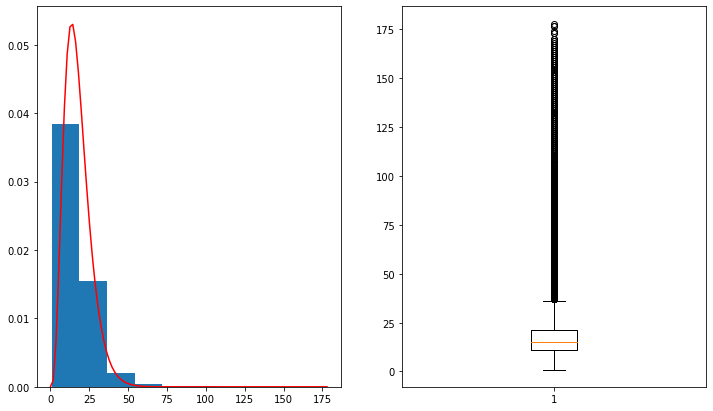

In [12]:
##### Investigate TAXI_OUT
# We wish to display the distribution along with a gamma distribution

# fit gamma distribution
gamma = ss.gamma
x = np.linspace(0, df.TAXI_OUT.max(), 100)
param = gamma.fit(df.TAXI_OUT, floc=0)
pdf_fitted = gamma.pdf(x, *param)

# Plot TAXI_OUT distribution, gamma distribution and boxplot of TAXI_OUT
fig,ax = plt.subplots(1,2,figsize=(12,7))
ax[0].hist(df.TAXI_OUT,density=True)
ax[0].plot(x, pdf_fitted, color='r')
ax[1].boxplot(df.TAXI_OUT)
print('Gamma distribution parameters: alpha = {}, loc={} and scale={}'.format(param[0],param[1],param[2]))

From the distribution plot we can see that it approximates a gamma-distribution with parameters alpha=4.48 and scale=3.92. Moreover, we can see that the boxplot indicates a significant amount of outliers. 

Next, lets examine the feature of airline names

<AxesSubplot:>

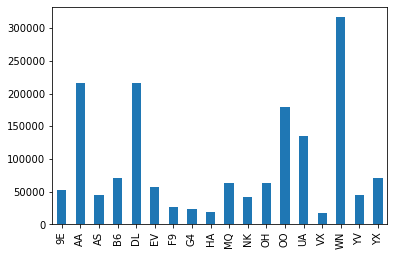

In [13]:
##### Investigate OP_CARRIER
origin_sum = df[onehot_carrier.columns].sum()
origin_sum.plot.bar()

We can see that the airline with the most flights in our data is WN which is SouthWest Airlines. Moreover, we can observe that the 5 airlines with most flights have significantly more flights than the rest. These 5 airlines are: 
- WN = SouthWest Airlines
- DL = Delta Airlines
- AA = American Airlines
- OO = SkyWest Airlines
- UA = United Airlines  

In [249]:
###### Investigate the ORIGIN feature
print('There is {} distinct origin airports'.format(len(onehot_origin.columns)))

There is 337 distinct origin airports


In [248]:
# The 10 busiest airports are
ko = onehot_origin.sum()
ind = np.argpartition(ko, -10)[-10:]
top10 = ko[ind]
print('The 10 busiest airports are')
top10


LAS    38434
PHX    43404
ATL    91196
DFW    64684
IAH    40800
CLT    53411
ORD    73653
DEN    53119
SFO    40836
LAX    51852
dtype: int64

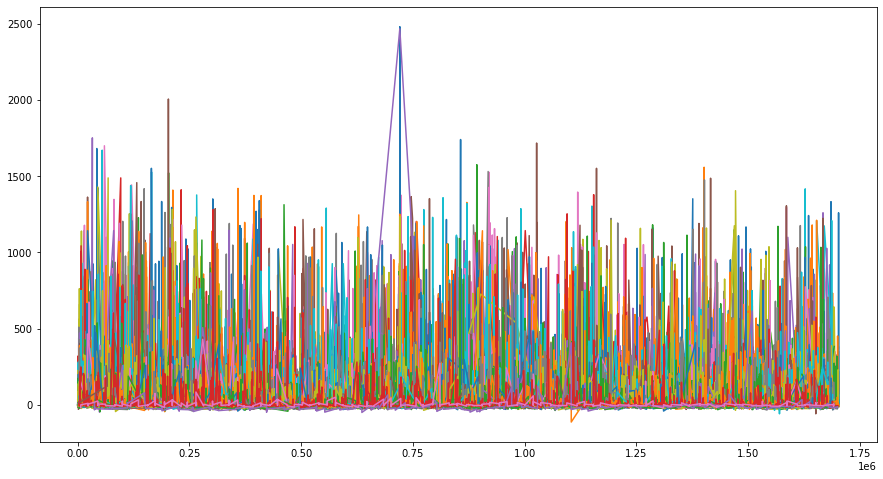

In [26]:
#### Investigate delay time across origins
fig = plt.subplots(1,figsize=(15,8))
for ori in onehot_origin.columns:
    ko = df[(df[ori] == 1)].DEP_DELAY
    plt.plot(ko)

In [151]:
# Compare shape to see effect of preprocessing
print('Shape before:',data.shape,'\n Shape after:',df.shape)

Shape before: (7213446, 28) 
 Shape after: (1659665, 356)


In [152]:
# Save as new dataframe
df.to_csv('Data/df_cush.csv',index=False)